### Create matrix of distances for all Patric Genome
Removing function 221 generic hypothetical

In [93]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time,json,os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.sparse import csr_matrix,csc_matrix
from scipy import sparse,stats
import scipy.spatial.distance as ssd
from __future__ import division

PATRIC_ANNOTATIONS_JSON_DIR="GenomeFeatures/"
PATRIC_ANNOTATIONS_JSON_ENDWITH="1-PatricAnnotations.txt"

PATRIC_VALID_TAXA="patric-16S.taxa_w_16S"
CLUSTERS_FILE="clusters.out"
SIMILARITY_TRESHOLD=0.1
CODE_FOR_HYPOTHETICAL_PROTEIN=221

def print_type(var):
    print(type(var).__name__)
def chomp(x):
    if x.endswith("\r\n"): return x[:-2]
    if x.endswith("\n"): return x[:-1]
    return x

In [32]:
json_files = [pos_json for pos_json in os.listdir(PATRIC_ANNOTATIONS_JSON_DIR) if pos_json.endswith(PATRIC_ANNOTATIONS_JSON_ENDWITH)]
print(json_files)

['91-PatricAnnotations.txt', '21-PatricAnnotations.txt', '81-PatricAnnotations.txt', '41-PatricAnnotations.txt', '31-PatricAnnotations.txt', '11-PatricAnnotations.txt', '71-PatricAnnotations.txt', '61-PatricAnnotations.txt', '51-PatricAnnotations.txt']


In [33]:
contents=[]
for file in json_files:
    contents.append(json.load(open(PATRIC_ANNOTATIONS_JSON_DIR+"/"+file)))

In [34]:
def chomp(x):
    if x.endswith("\r\n"): return x[:-2]
    if x.endswith("\n"): return x[:-1]
    return x
valid_hash = {}
with open(PATRIC_VALID_TAXA) as f:
    for line in f:
        valid_hash[chomp(str(line))] = 1

In [35]:
print(len(valid_hash))

106163


In [36]:
document_ids=[]
document_contents=[]
for data_json in contents:
    for key in data_json:
        if key in valid_hash:
            value = data_json[key]
            document_ids.append(key)
            value_filtered=[(x) for x in value if x != CODE_FOR_HYPOTHETICAL_PROTEIN]
            document_contents.append(str(value_filtered)[1:300])

In [44]:
len(document_contents)

7993

In [ ]:
vec = CountVectorizer()
X = csc_matrix(vec.fit_transform(document_contents))
#great resource understanding Compressed Data
#http://mbatchkarov.github.io/2014/10/10/rate_of_vocab_growth/
print(type(X).__name__)
print(X.shape)
print(X.shape[0])
print(len(X.indptr))
print("corresponding data row 0")
print(X[0])#row 0

In [ ]:
print([str(x) for x in vec.get_feature_names()[1:10]])
print(document_ids[:10])
print(str(document_contents[:1])[1:100])

### Reduce features for X -  create Y

In [ ]:
#we could also remove terms/functions that appear in a single document
print(X.shape)
print_type(X)
#print(X.A[1:20,1:20])
#colnamesX=vec.get_feature_names()
#print("colnames (",len(colnamesX),"):",colnamesX[:10],colnamesX[-2:])
numdocs=X.shape[0]
numdocs_gt_999=round(numdocs*0.999)
numdocs_lt_001=round(numdocs*0.001)
print("potential thresholds:",numdocs,numdocs_gt_999,numdocs_lt_001)
print(len(X.indptr))
cumulative_ids=(np.diff(X.indptr))
print("one id per term",len(cumulative_ids))
print("looking at single terms",pd.Series((cumulative_ids<=1)).value_counts())
print("looking at lt_001 percent across docs",pd.Series((cumulative_ids<=numdocs_lt_001)).value_counts())
print("looking at gt_999 percent across docs",pd.Series((cumulative_ids>=numdocs_gt_999)).value_counts())
#selected_ids=((cumulative_ids>numdocs_lt_001)&(cumulative_ids<numdocs_gt_999))
print("selecting term used in at least two documents")
selected_ids=((cumulative_ids>=2))
#colnamesY=list(compress(colnamesX,selected_ids))
#print("colnames (",len(colnamesY),"):",colnamesY[:10],colnamesY[-2:])
#print("colnames new size",len(colnamesY))
#print("selected matrix 20x20 example")
#print(Y.A[1:20,1:20])
Y=csr_matrix(X[:,selected_ids])
print(Y.shape)
print(len(Y.indptr))

### Pickle section Importing files

In [ ]:
#Save
sparse.save_npz('medium_matrix_Y.npz', Y)
np.save('medium_document_ids.npy', document_ids)

In [89]:
#load
#Y = csc_matrix(sparse.load_npz("medium_matrix_Y.npz"))
Z=np.load('/home/cesarcardona/Sloan_Surfaces/large/largeR6/large_linkage.npy')
#document_ids=np.load('/home/cesarcardona/Sloan_Surfaces/large/IN/large_document_ids.npy')

In [ ]:
import pickle
with open('_matrix.pkl', 'wb') as output:
    pickle.dump(X, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=document_ids)
print("REMOVE ID 221")
print(df.shape)
df = df.drop('221', 1)#generic hypthetical protein
print(df.shape)
print("GENOMES")
print(type(document_ids[1]).__name__)
print(len(document_ids))
print("CONTENTS")
print(type(document_contents[1]).__name__)
print(document_ids[1])
print("EXAMPLE")
print(df.iloc[1:10,1:10])

In [ ]:
import pickle
with open('_matrix.pkl', 'rb') as input:
    X = pickle.load(input)

In [ ]:
import pickle
with open('_distance.pkl', 'wb') as output:
    pickle.dump(dist, output, pickle.HIGHEST_PROTOCOL)

### Pickle section end

#### Reduce by rows, not practical not using it


In [ ]:
ids_selected=[]
start_time = time.time()
for i in range(0,X.shape[0]):
        #calculates one distance at the time, using two significant digits
        dist_i = np.round(1 - cosine_similarity(X[i],X),2)
        #removes the diagonal 0 value
        dist_i = np.delete(dist_i,i)
        #check if any distance is less than threshold to subset the data later on
        if(np.size(dist_i[(dist_i<=(1-MIN_SIMILARITY_TRESHOLD))])) > 0:
            #print(i,(dist_i[(dist_i<=(1-MIN_SIMILARITY_TRESHOLD))]))
            ids_selected.append(i)
        if(i%5000==4999):
            end_time = time.time()
            print("5000 elements added, time so far: ", round((end_time - start_time),2))
end_time = time.time()
print("total time taken this loop: ", round((end_time - start_time),2))
print(len(ids_selected))
print(ids_selected)

### Basic dist and distance comparison start

In [4]:
#too much memory
from sklearn.metrics.pairwise import cosine_similarity
dist = np.round(1 - cosine_similarity(Y),2)

In [5]:
print(dist.shape)
print(dist[1:5,1:5])
print_type(dist)
dist


(7993, 7993)
[[-0.    0.98  1.    0.96]
 [ 0.98 -0.    0.94  0.98]
 [ 1.    0.94  0.    0.98]
 [ 0.96  0.98  0.98 -0.  ]]
ndarray


array([[-0.  ,  1.  ,  0.95, ...,  0.98,  0.87,  1.  ],
       [ 1.  , -0.  ,  0.98, ...,  1.  ,  1.  ,  1.  ],
       [ 0.95,  0.98, -0.  , ...,  1.  ,  1.  ,  1.  ],
       ..., 
       [ 0.98,  1.  ,  1.  , ..., -0.  ,  0.89,  1.  ],
       [ 0.87,  1.  ,  1.  , ...,  0.89,  0.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  , ...,  1.  ,  1.  , -0.  ]])

In [ ]:
dist_i=1-np.round(cosine_similarity(X[22],X),2)
print(dist_i)
print(np.delete(dist_i,22))

In [ ]:
print(dist[1] == dist_i)
df=pd.Series([dist[1] == dist_i])
print(df)
print(type(dist_i).__name__)
print(X.shape)
print(X.shape[0])

### Distance comparison end

### Aggregated clusteing takes too long to run - not used

### Hirarchical clustering - GOOD option


In [104]:
# convert the redundant n*n square matrix form into a condensed nC2 array
print("dist shape",dist.shape)
distArray = ssd.squareform(dist)
print("dist array shape", distArray.shape)
Z = linkage(distArray, 'average')

('dist shape', (7993, 7993))
('dist array shape', (31940028,))


In [4]:
print(Z.shape)
print_type(Z)
print(Z[:3])

(106151, 4)
ndarray
[[  9.02890000e+04   9.93200000e+04   0.00000000e+00   2.00000000e+00]
 [  9.21250000e+04   1.00291000e+05   0.00000000e+00   2.00000000e+00]
 [  9.21220000e+04   9.46810000e+04   0.00000000e+00   2.00000000e+00]]


In [161]:
1/(range(100,1000,30)[14])

0.0019230769230769232

In [215]:
thresholds=[]
ratios=[]
for i in np.logspace(2,5,num=30, endpoint=False):#(range(100,1000,30)):
    threshold=round(1/i,6)
    #print threshold
    clusters = fcluster(Z, threshold, criterion='distance')
    #print("clusterids", clusters)
    #print_type(clusters)
    #print('before',clusters.shape)
    #print('after',np.unique(clusters).shape)
    numclusters=stats.describe(clusters)[1][1]
    #print(numclusters)
    numdocs=clusters.shape[0]
    percent_consolidated=round((1-numclusters/ float(numdocs))*100,2)
    ratios.append(numclusters)
    thresholds.append(threshold)
    #print(str(percent_consolidated)+"% genomes consolidated")
df = pd.DataFrame({'numclusters':list(reversed(ratios)),'thresholds':list(reversed(thresholds))})

In [216]:
df

numclusters  thresholds
0        105852    0.000013
1        105834    0.000016
2        105804    0.000020
3        105765    0.000025
4        105689    0.000032
5        105586    0.000040
6        105469    0.000050
7        105298    0.000063
8        105069    0.000079
9        104732    0.000100
10       104239    0.000126
11       103561    0.000158
12       102632    0.000200
13       101474    0.000251
14        99910    0.000316
15        98017    0.000398
16        95750    0.000501
17        93066    0.000631
18        90197    0.000794
19        86945    0.001000
20        83536    0.001259
21        79975    0.001585
22        76408    0.001995
23        72797    0.002512
24        69165    0.003162
25        65517    0.003981
26        61769    0.005012
27        58009    0.006310
28        54293    0.007943
29        50489    0.010000

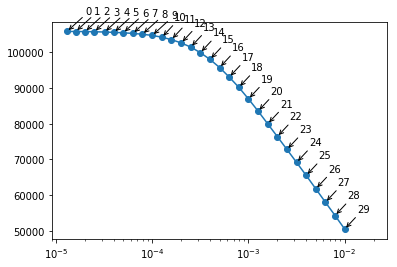

[(1, -16.666666666666668), (2, -13.333333333333341), (3, -12.820512820512818), (4, -9.2105263157894708), (5, -7.7669902912621405), (6, -8.5470085470085451), (7, -7.6023391812865482), (8, -6.9868995633187749), (9, -6.2314540059347205), (10, -5.2738336713995935), (11, -4.7197640117994082), (12, -4.5209903121636188), (13, -4.4041450777202042), (14, -4.156010230179028), (15, -4.331748547279453), (16, -4.5434494927216589), (17, -4.8435171385991067), (18, -5.681422098292086), (19, -6.3345633456334571), (20, -7.597535934291578), (21, -9.1547318169053682), (22, -11.494252873563212), (23, -14.317363611188039), (24, -17.896475770925107), (25, -22.45065789473685), (26, -27.508004268943431), (27, -34.521276595744673), (28, -43.945102260495176), (29, -54.074658254468979)]
2      3.333333
3      0.512821
4      3.609987
5      1.443536
6     -0.780018
7      0.944669
8      0.615440
9      0.755446
10     0.957620
11     0.554070
12     0.198774
13     0.116845
14     0.248135
15    -0.175738
16    

In [231]:
plt.scatter(df.thresholds,df.numclusters)
plt.plot(df.thresholds,df.numclusters)
plt.xscale('log')

for label, x, y in zip((range(0,df.shape[0])), df.thresholds, df.numclusters):
    plt.annotate(
        label,
        xy=(x, y), xytext=(25, 15),
        textcoords='offset points', ha='right', va='bottom',
        #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()
deltas=df.diff().drop(0)
#gradient=np.gradient(deltas)
#print(gradient)
#print(deltas2)
slope=(deltas['thresholds']/deltas['numclusters'])*100000000
slope_diff=(slope.diff().drop(1))
print(zip(range(1,df.shape[0]),slope))
print(slope_diff)
#slope = 
#plt.savefig('clusters_vs_threshold_log.pdf', dpi=50)

In [40]:
outfile = open (CLUSTERS_FILE, "w")
print(document_ids[:4])
len_docs=len(document_ids)
print(len_docs)
doc_hash={}
for i in range(0,len_docs):
    if clusters[i] in doc_hash:
        outfile.write(str(document_ids[i])+"\t"+str(doc_hash[clusters[i]])+"\n")
    else:
        doc_hash[clusters[i]]=document_ids[i]
        outfile.write(str(document_ids[i])+"\t"+str(document_ids[i])+"\n")
outfile.close()

[u'914135.3', u'913328.3', u'911122.5', u'911119.5']
7993


### Fancy plotting

In [41]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [42]:
plt.figure(figsize=(300, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=2.,  # font size for the x axis labels
)
print("Done")

Done


In [43]:
plt.savefig('clustering_ave.pdf', dpi=100)

In [46]:
plt.figure(figsize=(15,10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=6.,
    show_contracted=True,
    annotate_above=40,
    max_d=SIMILARITY_TRESHOLD,
)
print("Done","plt.show()")

('Done', 'plt.show()')


In [47]:
plt.savefig('clustering_ave_line.pdf', dpi=100)

### Compare docs

In [99]:
def compare_two_docs(doc1,doc2):
    str1=document_contents[document_ids.index(doc1)]
    str2=document_contents[document_ids.index(doc2)]
    print("doc1")
    print(str1)
    print("doc2")
    print(str2)
    print("diff")
    set1=set(str1.replace(" ", "").split(","))
    set2=set(str2.replace(" ", "").split(","))
    print(set1^set2)

In [100]:
compare_two_docs("813.131","718219.3")

doc1
2491, 9711, 9712, 38, 39, 286, 218, 219, 213, 12, 231, 2, 3, 4, 5, 160, 921, 9714, 11, 1679, 814, 1626, 9713, 1633, 653, 5095, 1200, 4163, 1087, 1463, 494, 9715, 313, 923, 9716, 9716, 1108, 1781, 9717, 3393, 228, 4179, 1106, 9416, 1256, 3204, 81, 79, 80, 78, 322, 9710, 1291, 187, 9718, 1616, 1989, 
doc2
9711, 9712, 38, 39, 286, 218, 219, 213, 12, 231, 2, 3, 4, 5, 160, 921, 9714, 11, 814, 1679, 1626, 9713, 1633, 653, 5095, 1200, 4163, 1087, 1463, 494, 9715, 313, 923, 9716, 9716, 1108, 1781, 9717, 3393, 228, 4179, 1106, 9416, 1256, 3204, 81, 79, 80, 78, 322, 1291, 187, 9710, 9718, 1616, 1989, 360, 3
diff
set(['', '2491', '360'])


In [101]:
compare_two_docs("1151324.3","1151325.4")

doc1
4967, 4968, 4969, 9386, 534, 30474, 1715, 30443, 3201, 3422, 3419, 4549, 1701, 4308, 512, 313, 1540, 1541, 21872, 8041, 1202, 627, 4088, 4272, 4689, 8354, 8355, 7111, 1555, 168, 2428, 4183, 925, 4109, 4110, 292, 27932, 4108, 807, 4153, 6366, 2967, 1563, 124, 213, 314, 891, 736, 11850, 826, 13, 1174
doc2
4967, 4968, 4969, 9386, 534, 30474, 1715, 30443, 3201, 3422, 3419, 4549, 1701, 4308, 512, 313, 1540, 1541, 21872, 8041, 1202, 627, 4088, 4272, 4689, 8354, 8355, 7111, 1555, 168, 2428, 4183, 925, 4109, 4110, 292, 27932, 4108, 807, 4153, 6366, 2967, 1563, 124, 213, 314, 891, 736, 11850, 826, 13, 1174
diff
set([])


In [102]:

compare_two_docs("515620.21","515620.4")

doc1
5491, 1751, 3510, 3438, 4045, 13209, 5999, 25941, 2565, 7072, 696, 4601, 665, 858, 1648, 5719, 5999, 62, 194, 7435, 6002, 460, 903, 5928, 612, 445, 5263, 5264, 5256, 38, 4239, 178569, 175, 33956, 34785, 1519, 524, 8728, 4177, 766, 464, 3199, 18068, 4246, 4249, 4250, 4254, 5875, 4262, 15668, 2490, 4
doc2
5491, 1751, 3510, 3438, 4045, 13209, 25941, 2565, 7072, 696, 4601, 665, 858, 1648, 5719, 62, 194, 7435, 6002, 460, 903, 5928, 612, 445, 5263, 5264, 5256, 38, 4239, 175, 33956, 34785, 1519, 524, 8728, 4177, 766, 464, 3199, 18068, 4246, 4249, 4250, 4254, 5875, 4262, 15668, 2490, 4289, 251, 1913, 1165
diff
set(['1165', '251', '4289', '4', '178569', '1913', '5999'])


In [71]:
import scipy.sparse as sp
mat = sp.rand(5, 4, 0.4, format='csc')
mat_r = sp.rand(5, 4, 0.4, format='csr')
mat_r_c= csc_matrix(mat_r.T)

In [52]:
print(mat.A)

[[ 0.20781586  0.28085895  0.          0.        ]
 [ 0.43901424  0.          0.69306796  0.65878438]
 [ 0.8616194   0.          0.07852212  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.01733284  0.          0.          0.        ]]


In [75]:
mat.data[:]=1
mat_r.data[:]=1
mat_r_c.data[:]=1


In [76]:
print(mat_r.A)
print(mat_r_c.A)


[[ 0.  1.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  1.]]
[[ 0.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  1.  1.  1.]]


In [87]:
%time print(jaccard_similarities(mat_r_c).A)
%time print(jaccard_similarities_deb(mat_r_c).A)


[[ 1.          0.          1.          0.5         0.33333333]
 [ 0.          1.          0.          0.          0.        ]
 [ 1.          0.          1.          0.5         0.33333333]
 [ 0.5         0.          0.5         1.          0.5       ]
 [ 0.33333333  0.          0.33333333  0.5         1.        ]]
CPU times: user 3 ms, sys: 4 ms, total: 7 ms
Wall time: 4.69 ms
[2 1 2 1 2]
[[ 2.  0.  2.  1.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 2.  0.  2.  1.  1.]
 [ 1.  0.  1.  1.  1.]
 [ 1.  0.  1.  1.  2.]]
[4 1 4 4 4]
[2 2 2 2 1 2 2 2 2 1 1 1 1 2 2 2 2]
[4 3 2 0 1 4 3 2 0 4 3 2 0 3 2 0 4]
[2 1 2 2 1 2 1 2 2 2 1 2 2 1 2 2 2]
[[ 0.          0.          0.          0.5         0.66666667]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.5         0.66666667]
 [ 0.5         0.          0.5         0.          0.5       ]
 [ 0.66666667  0.          0.66666667  0.5         0.        ]]
CPU times: user 14 ms, sys: 3 ms, total: 17 ms
Wall time

In [83]:
def jaccard_similarities_deb(mat):
    cols_sum = mat.getnnz(axis=0)
    print(cols_sum)
    ab = mat.T * mat
    print(ab.A)
    print(ab.getnnz(axis=0))

    # for rows
    aa = np.repeat(cols_sum, ab.getnnz(axis=0))
    print(aa)
    # for columns
    print(ab.indices)
    bb = cols_sum[ab.indices]
    print(bb)

    similarities = ab.copy()
    similarities.data /= (aa + bb - ab.data)
#     disimilarities = similarities.copy()
#     disimilarities.data = 1
#     disimilarities.data = (1 - similarities.data)
#     return similarities
def jaccard_similarities(mat):
    cols_sum = mat.getnnz(axis=0)
    ab = mat.T * mat

    # for rows
    aa = np.repeat(cols_sum, ab.getnnz(axis=0))
    # for columns
    bb = cols_sum[ab.indices]

    similarities = ab.copy()
    similarities.data /= (aa + bb - ab.data)

    return similarities